# Basic Prototype 2

Builds on Basic Prototype 1, adds yolov8 pose detection. Landmarks will be saved in a datastructure which then will be visualised and probably exported as a JSON so that it can be trained on Google Colab. This prototype focuses on testing if an AI model can be trained to interpolate and output the correct landmarks to continue the video sequence after being trained on the sequences of the videos.

Pose detection wise, Openpose is better since it has more landmarks and also tracks the foot, it is also based on C++ so it's quicker, but I cannot get openpose to work yet, so I will implement using YOLOv8 for now just to test the AI model structure. 

Mediapipe is also a possibility but it can only detect 1 person at a time and is much slower. 

Still the broadcast on OBS has to be started manually first.

In [11]:
# imports

import pytchat
import cv2
import glob
import ultralytics
import torch
import time
import numpy as np
from collections import defaultdict
import pandas as pd

files = glob.glob('G:/UAL_Thesis/raw_videos/*')
print(files[0])


G:/UAL_Thesis/raw_videos\idle_bob_1.MOV


In [2]:
def plot_keypoints(frame, predictions):
    # Plot pose keypoints to image
    keypoints_per_frame_dict = {}
    for idx in range(output.shape[0]):

        output_coord = output[idx, 7:]
        keypoints_per_frame_dict[idx] = output_coord.tolist()

        # output is x,y,confidence for each keypoint
        plot_skeleton_kpts(im0, output[idx, 7:].T, 3)
        xmin, ymin = (output[idx, 2] - output[idx, 4] / 2), (output[idx, 3] - output[idx, 5] / 2)
        xmax, ymax = (output[idx, 2] + output[idx, 4] / 2), (output[idx, 3] + output[idx, 5] / 2)

        #Plotting key points from pose detection on Image
        cv2.rectangle(frame, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color=(255, 0, 0),
                        thickness=1, lineType=cv2.LINE_AA)
        
    return frame 

In [3]:
from PIL import Image

def draw_skeleton(result):
    """draw frame from YOLOv8 results"""
    for r in result:
        im_array = r.plot()  # plot a BGR numpy array of predictions
        im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    return np.array(im)[..., ::-1]  # Convert PIL Image back to BGR numpy array

In [4]:
# test YOLOv8 pose recognition with 1 file first



"""Check hardware and load model"""


# Check if GPU is available otherwise use CPU for torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# If GPU is available set model to use half-precision floating-point numbers
if torch.cuda.is_available():
    model.half().to(device)

# load model
video_path = files[0]
model = ultralytics.YOLO('yolov8n-pose.pt')

# predict

cap = cv2.VideoCapture(video_path)
start_time = time.time()

# resize cv2 window

# Get the original video dimensions
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the desired width and calculate the height to maintain the aspect ratio
desired_width = 540  # You can change this value
aspect_ratio = height / width
desired_height = int(desired_width * aspect_ratio)

# Get video, pose analyse and display pose detection frame by frame
pose_results = defaultdict(int)
i=0

while(cap.isOpened() and time.time()):
    ret, frame = cap.read()
    if ret == True:
        result = model.predict(frame)
        pose_results[i] = result
        i = i+1
        annotated_frame = draw_skeleton(result)
        # Resize the frame while maintaining the aspect ratio
        resized_frame = cv2.resize(annotated_frame, (desired_width, desired_height))
        cv2.imshow('Frame', resized_frame)
        
        # Press Q on keyboard to exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()
cv2.destroyAllWindows 





0: 640x384 1 person, 71.0ms
Speed: 3.0ms preprocess, 71.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 46.8ms
Speed: 2.0ms preprocess, 46.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 46.0ms
Speed: 2.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 46.0ms
Speed: 2.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 43.1ms
Speed: 2.0ms preprocess, 43.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 44.0ms
Speed: 2.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 45.0ms
Speed: 2.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 43.9ms
Speed: 2.0ms preprocess, 43.9ms inference, 0.0ms postprocess per image at shape (1, 3, 64

<function destroyAllWindows>

In [27]:
from collections import defaultdict

# LSTM - adapted from AI for media 
# https://git.arts.ac.uk/tbroad/AI-4-Media-22-23/blob/main/Week%205.1%20LSTM%20for%20forecasting%20and%20movement%20generation/Generating_Movement_Sequences_with_LSTM.ipynb

# define keypoints
keypoints = {
    "nose": 0,
    "left_eye": 1,
    "right_eye": 2,
    "left_ear": 3,
    "right_ear": 4,
    "left_shoulder": 5,
    "right_shoulder": 6,
    "left_elbow": 7,
    "right_elbow": 8,
    "left_wrist": 9,
    "right_wrist": 10,
    "left_hip": 11,
    "right_hip": 12,
    "left_knee": 13,
    "right_knee": 14,
    "left_ankle": 15,
    "right_ankle": 16
}


# convert tensor of xy coordinate per frame into a pandas time series
keypoints_dict_master = defaultdict(dict)

for frame, results in pose_results.items():
    for idx, person in enumerate(results):
        # Check if person has the attribute 'keypoints' and it has the attribute 'xy'
        if hasattr(person, 'keypoints') and hasattr(person.keypoints, 'xy'):
            tensor_values = person.keypoints.xy
            
            # Convert tensor to dictionary format
            keypoint_coordinates = {key: tensor_values[0][value] for key, value in keypoints.items() if value < len(tensor_values[0])}
            
            # Use idx as a unique identifier for each person
            keypoints_dict_master[frame][idx] = keypoint_coordinates


In [31]:
# convert to pandas of each keypoint coordinate for each frame

# Flatten the dictionary
rows = []
for frame, persons in keypoints_dict_master.items():
    for person, keypoints in persons.items():
        row = {'frame': frame, 'person': person}
        for keypoint, coordinates in keypoints.items():
            row[f'{keypoint}_x'] = coordinates[0]
            row[f'{keypoint}_y'] = coordinates[1]
        rows.append(row)

# Convert to DataFrame
df = pd.DataFrame(rows)

df

,frame,person,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0,0,tensor(572.5844),tensor(387.1520),tensor(608.4468),tensor(353.7876),tensor(532.8524),tensor(357.9723),tensor(664.1659),tensor(384.3369),...,tensor(469.7200),tensor(1064.7975),tensor(626.0299),tensor(1454.7532),tensor(474.2142),tensor(1443.3110),tensor(598.1318),tensor(1764.0773),tensor(484.6975),tensor(1753.0880)
1,1,0,tensor(571.2889),tensor(386.6899),tensor(608.6426),tensor(353.9558),tensor(532.3405),tensor(356.7040),tensor(664.7523),tensor(385.8188),...,tensor(469.7144),tensor(1063.9468),tensor(625.3629),tensor(1452.9130),tensor(471.3136),tensor(1443.1890),tensor(596.1293),tensor(1760.0026),tensor(484.3914),tensor(1753.0950)
2,2,0,tensor(572.3378),tensor(388.0645),tensor(607.7379),tensor(354.7126),tensor(532.4883),tensor(359.0193),tensor(661.3995),tensor(383.4742),...,tensor(470.4005),tensor(1064.5540),tensor(625.4920),tensor(1450.5900),tensor(472.0074),tensor(1442.4648),tensor(595.7187),tensor(1758.4951),tensor(481.5737),tensor(1750.5928)
3,3,0,tensor(570.7042),tensor(388.4200),tensor(606.2318),tensor(355.5103),tensor(531.7367),tensor(359.4512),tensor(660.9133),tensor(385.0552),...,tensor(469.4697),tensor(1063.4103),tensor(624.7820),tensor(1449.9408),tensor(470.5060),tensor(1439.7177),tensor(596.3668),tensor(1756.1847),tensor(480.5498),tensor(1746.3779)
4,4,0,tensor(569.7440),tensor(386.5835),tensor(606.0142),tensor(353.6583),tensor(530.1858),tensor(357.4964),tensor(661.3528),tensor(385.0500),...,tensor(468.2738),tensor(1064.0929),tensor(623.8318),tensor(1450.9092),tensor(470.0614),tensor(1441.2657),tensor(595.5956),tensor(1755.8397),tensor(481.9343),tensor(1746.9474)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,233,0,tensor(551.8484),tensor(288.8281),tensor(589.8433),tensor(260.7991),tensor(518.8748),tensor(261.1967),tensor(646.0545),tensor(305.5212),...,tensor(452.7424),tensor(1003.2184),tensor(605.9675),tensor(1376.2036),tensor(452.4008),tensor(1363.0005),tensor(593.5286),tensor(1672.0087),tensor(492.5339),tensor(1662.3289)
234,234,0,tensor(551.2506),tensor(288.0756),tensor(589.7824),tensor(260.1300),tensor(518.7757),tensor(259.9391),tensor(647.7039),tensor(305.7157),...,tensor(452.5389),tensor(1003.2959),tensor(606.6724),tensor(1377.8911),tensor(453.6025),tensor(1362.3275),tensor(592.5033),tensor(1673.2881),tensor(492.8368),tensor(1661.4800)
235,235,0,tensor(551.1454),tensor(286.3479),tensor(589.9506),tensor(257.3360),tensor(518.4791),tensor(257.9067),tensor(650.6882),tensor(301.5788),...,tensor(452.2980),tensor(1003.1681),tensor(608.0409),tensor(1377.6168),tensor(454.9499),tensor(1361.6554),tensor(593.6854),tensor(1672.0071),tensor(492.5299),tensor(1659.7152)
236,236,0,tensor(552.7637),tensor(287.3988),tensor(591.5782),tensor(258.3112),tensor(520.4485),tensor(258.6328),tensor(652.4534),tensor(301.6352),...,tensor(452.5466),tensor(1002.8945),tensor(609.9174),tensor(1377.6414),tensor(457.4650),tensor(1361.2084),tensor(594.9216),tensor(1672.8462),tensor(493.4562),tensor(1660.4020)


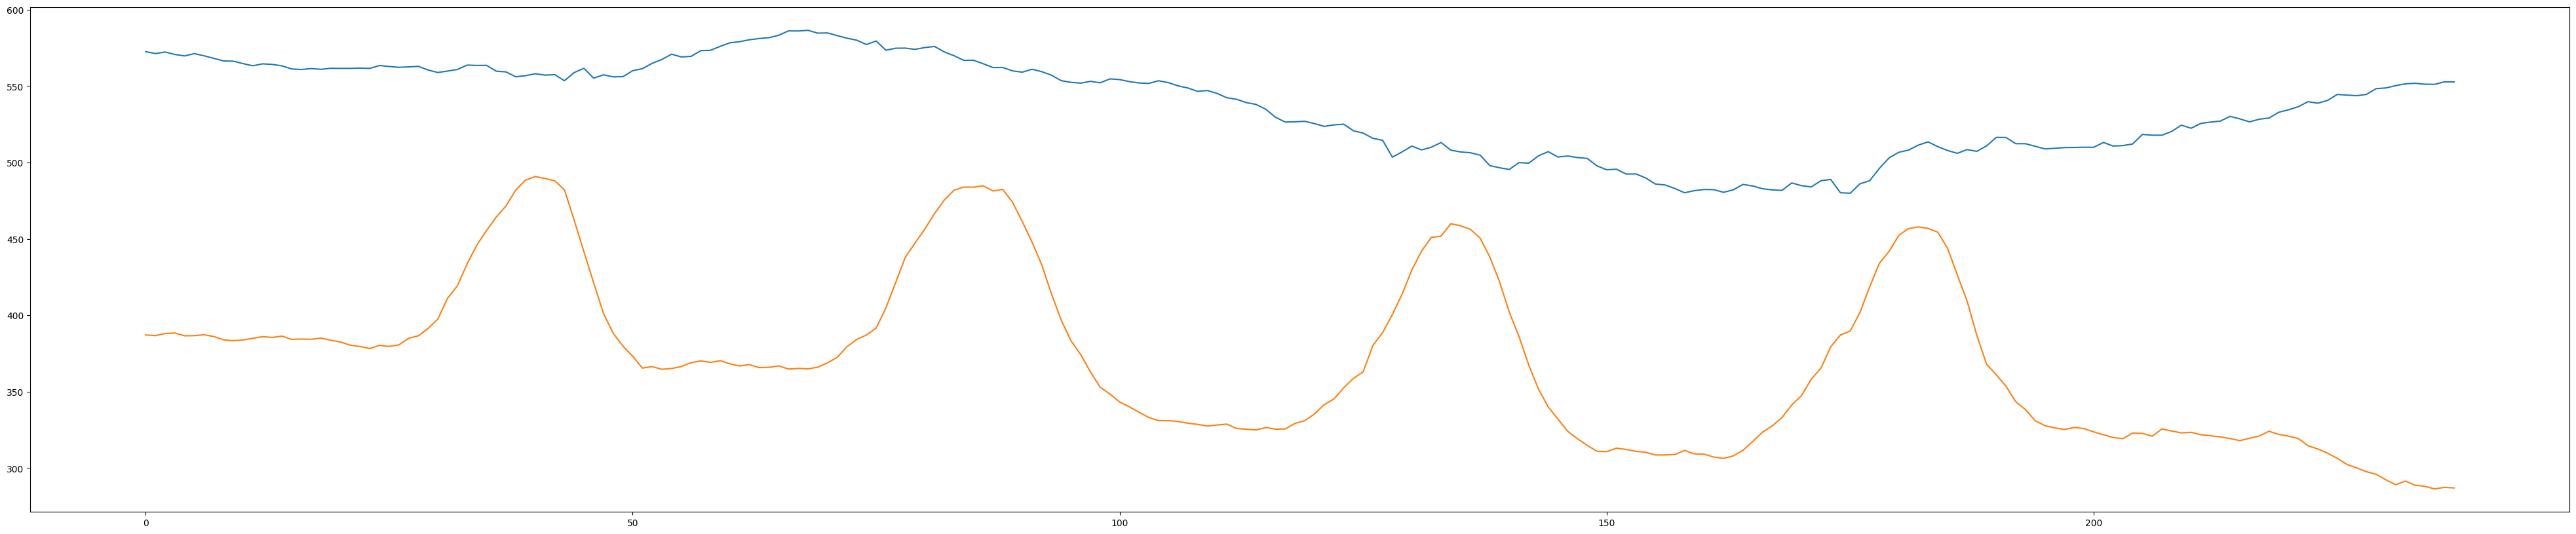

In [34]:
import matplotlib.pyplot as plt

# sample visualise change in nose_x, nose_y position

# Plotting the change of coordinates values for 1 body joint, e.g. the nose
plt.figure(figsize=(50, 10))

plt.plot(df['nose_x']) #blue line
plt.plot(df['nose_y']) #orange line

plt.show()

In [6]:
# transformers taken from Aksan et al 2021

In [7]:
# https://docs.ultralytics.com/modes/predict/#keypoints

for person in result:
   print(person.keypoints.xy)

tensor([[[ 552.7383,  287.0104],
         [ 591.7453,  257.0405],
         [ 518.8950,  258.0854],
         [ 652.9227,  299.5885],
         [ 476.9171,  303.4793],
         [ 714.7808,  535.6921],
         [ 419.1434,  538.5583],
         [ 752.4368,  830.2319],
         [ 352.4036,  835.3380],
         [ 741.5168, 1074.6621],
         [ 337.3322, 1073.6311],
         [ 639.0662, 1007.6199],
         [ 453.4530, 1003.4804],
         [ 611.6160, 1378.3107],
         [ 457.7248, 1361.6741],
         [ 594.8438, 1669.9037],
         [ 492.4857, 1656.2008]]])


In [8]:
im_array

NameError: name 'im_array' is not defined

In [ ]:
# code AI